In [26]:
# %% [markdown]
# # Tran et al. inclusions: micro → meso → macro

In [27]:
from dataclasses import dataclass
from pathlib import Path
from typing import Literal, Optional
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(str(Path.cwd().parent))

from diffmap.lifting import (
    build_training_pairs,
    build_time_augmented_training_pairs,
    compute_lift_metrics,
    lift_with_convex_hull,
    lift_with_geometric_harmonics,
    lift_with_time_local_kernel_ridge,
    print_metric_table,
)
from mmsfm.data_utils import (
    find_holdout_index,
    get_marginals,
    invert_pca,
    pca_decode,
    split_train_holdout_marginals,
    to_images,
)
from mmsfm.viz import format_for_paper, plot_error_statistics, plot_field_comparisons

data_path = Path("../data/tran_inclusions.npz")
npz = np.load(data_path)
resolution = int(np.sqrt(int(npz["data_dim"])))

# Debug: print all available keys
print("Available keys in npz:", list(npz.files))

# Extract available times from marginals (not raw_marginal_)
time_keys = [k for k in npz.files if k.startswith("marginal_")]
times = sorted(float(k.replace("marginal_", "")) for k in time_keys)
print("Times:", times)

format_for_paper()

Available keys in npz: ['data_dim', 'dataset_format', 'scale_mode', 'scaling_epsilon', 'data_generator', 'minmax_data_min', 'minmax_data_scale', 'raw_marginal_0.0', 'raw_marginal_0.25', 'raw_marginal_0.5', 'raw_marginal_0.75', 'raw_marginal_1.0', 'marginal_0.0', 'marginal_0.25', 'marginal_0.5', 'marginal_0.75', 'marginal_1.0', 'pca_components', 'pca_mean', 'pca_explained_variance', 'is_whitened', 'whitening_epsilon']
Times: [0.0, 0.25, 0.5, 0.75, 1.0]


Available keys in npz: ['data_dim', 'dataset_format', 'scale_mode', 'scaling_epsilon', 'data_generator', 'minmax_data_min', 'minmax_data_scale', 'raw_marginal_0.0', 'raw_marginal_0.25', 'raw_marginal_0.5', 'raw_marginal_0.75', 'raw_marginal_1.0', 'marginal_0.0', 'marginal_0.25', 'marginal_0.5', 'marginal_0.75', 'marginal_1.0', 'pca_components', 'pca_mean', 'pca_explained_variance', 'is_whitened', 'whitening_epsilon']
Using mode: pca Found times: [0.0, 0.25, 0.5, 0.75, 1.0]


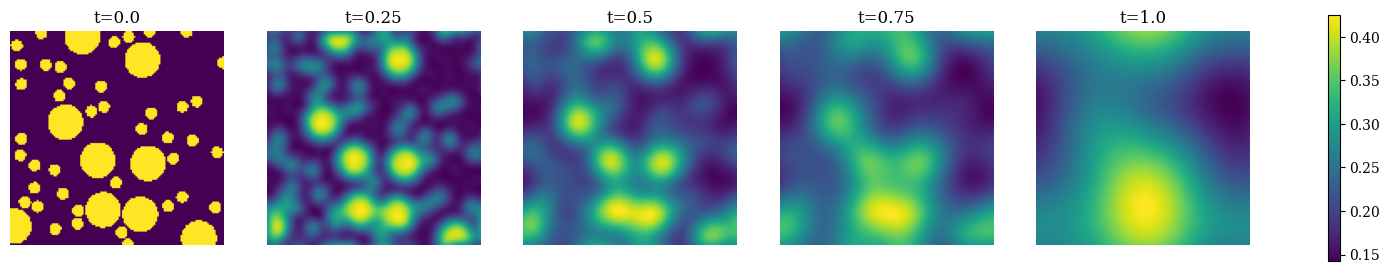

In [28]:
# Debug: show available keys
print("Available keys in npz:", list(npz.files))

# Acquire marginals (raw preferred; PCA otherwise)
times, marginals, mode = get_marginals(npz, choice="pca")
_, raw_marginals, _ = get_marginals(npz, choice="raw")
held_out_indices = npz.get("held_out_indices")
if held_out_indices is not None:
    held_out_indices = np.asarray(held_out_indices, dtype=int)
else:
    held_out_indices = np.array([], dtype=int)

train_times, train_marginals, held_out_times, held_out_marginals, used_held_out_indices = split_train_holdout_marginals(
    times,
    marginals,
    held_out_indices,
)
times, marginals = train_times, train_marginals
print("Using mode:", mode, "Found times:", times)
if held_out_times:
    print(
        f"Held-out times at indices {used_held_out_indices}: {held_out_times} (excluded from training)"
    )

# Load PCA metadata (used only when mode == 'pca')
components = npz.get("pca_components")
mean_vec = npz.get("pca_mean")
explained_variance = npz.get("pca_explained_variance")
is_whitened = bool(npz.get("is_whitened", False))
whitening_epsilon = float(npz.get("whitening_epsilon", 0.0))

# Visualise one sample across times
sample_idx = 0
ncols = len(times)
if ncols == 0:
    raise RuntimeError("No times found to plot. Check the npz keys printed above.")

fig, axes = plt.subplots(1, max(1, ncols), figsize=(4 * max(1, ncols), 4))
if ncols == 1:
    axes = [axes]

for ax, (i,t) in zip(axes, enumerate(times)):
    data = marginals[t]
    if sample_idx >= data.shape[0]:
        raise IndexError(f"sample_idx {sample_idx} out of range for time {t} (len={data.shape[0]})")

    if mode == "pca":
        if i == 0:
            field = raw_marginals[i][sample_idx].reshape(resolution, resolution)
        else:
            recon = invert_pca(data, components, mean_vec, explained_variance, is_whitened, whitening_epsilon)
            field = recon[sample_idx].reshape(resolution, resolution)
    else:
        field = data[sample_idx].reshape(resolution, resolution)

    im = ax.imshow(field, cmap="viridis")
    ax.set_title(f"t={t}")
    ax.axis("off")

fig.colorbar(im, ax=axes[:ncols], shrink=0.8)
plt.show()

# %% [markdown]
# ## Data Loading & Preparation
# Convert the PCA marginal dictionary into a time-major tensor for downstream analysis.

In [29]:
# Assemble PCA snapshots into a tensor (time, samples, components)
times_arr = np.array(times, dtype=np.float64)
all_frames = np.stack([marginals[t] for t in times_arr])
# exclude first time since it is for visualization only
all_frames = all_frames[1:]
times_arr = times_arr[1:]
n_times, n_samples, n_components = all_frames.shape

print(f"All frames tensor shape: {all_frames.shape} (time x samples x components)")
print(f"Unique times: {times_arr}")
print(f"Number of PCA components: {n_components}")

# %% [markdown]
# ## PCA Visualization
# Inspect how the first two PCA coefficients evolve over time before constructing diffusion maps.

All frames tensor shape: (4, 1000, 390) (time x samples x components)
Unique times: [0.25 0.5  0.75 1.  ]
Number of PCA components: 390


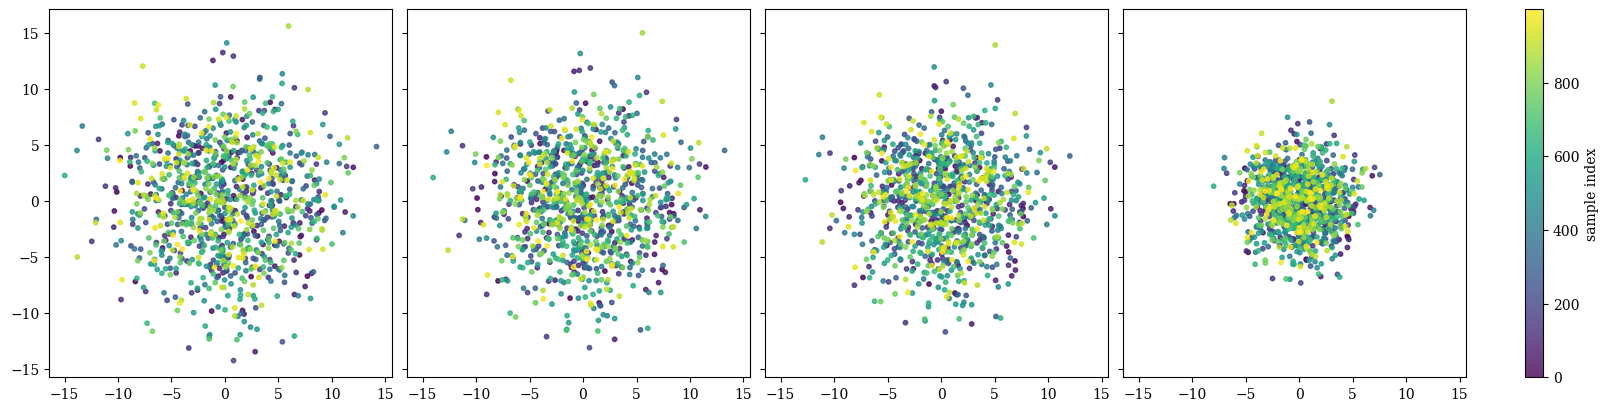

In [30]:
rng = np.random.default_rng(0)
subset = min(2000, n_samples)
if subset < n_samples:
    sample_idx_subset = rng.choice(n_samples, size=subset, replace=False)
else:
    sample_idx_subset = np.arange(n_samples)

fig, axes = plt.subplots(
    1, n_times, figsize=(4 * n_times, 4), sharex=True, sharey=True, constrained_layout=True
)
if n_times == 1:
    axes = [axes]

# color by sample id (consistent across panels)
sample_ids = np.arange(len(sample_idx_subset))
for i, ax in enumerate(axes):
    coords = all_frames[i, sample_idx_subset, :]
    sc = ax.scatter(coords[:,0], coords[:,1], c=sample_ids,
                    cmap='viridis', s=10, alpha=0.8)
fig.colorbar(sc, ax=axes, label='sample index', fraction=0.046, pad=0.04)

plt.show()


# %% [markdown]
# ## Diffusion Hyperparameters
# Set the parameters for the variable-bandwidth time-coupled diffusion map experiment.

In [31]:
tc_k = 8
tc_alpha = 0.5
tc_beta = -0.2
use_variable_bandwidth = True

print(f"Diffusion config → k={tc_k}, alpha={tc_alpha}, beta={tc_beta}, variable_bandwidth={use_variable_bandwidth}")


# %% [markdown]
# ## Bandwidth Analysis
# Tune per-time diffusion bandwidths by targeting a fixed effective neighbour count.

Diffusion config → k=8, alpha=0.5, beta=-0.2, variable_bandwidth=True


In [32]:

from scipy.spatial.distance import pdist, squareform
from diffmap.diffusion_maps import (
    select_epsilons_by_connectivity,
    time_coupled_diffusion_map,
    build_time_coupled_trajectory,
    fit_coordinate_splines,
    evaluate_coordinate_splines,
    fit_geometric_harmonics,
    geometric_harmonics_lift,
    geometric_harmonics_lift_local,
    ConvexHullInterpolator,
    GeometricHarmonicsModel,
)


def compute_bandwidth_statistics(frames: np.ndarray) -> dict[str, np.ndarray]:
    medians, q1, q3, maxima = [], [], [], []
    for snapshot in frames:
        d2 = squareform(pdist(snapshot, metric='sqeuclidean'))
        mask = d2 > 0
        if np.any(mask):
            vals = d2[mask]
        else:
            vals = np.array([1.0])
        medians.append(float(np.median(vals)))
        q1.append(float(np.percentile(vals, 25)))
        q3.append(float(np.percentile(vals, 75)))
        maxima.append(float(np.max(vals)))
    return {
        'median': np.array(medians),
        'q1': np.array(q1),
        'q3': np.array(q3),
        'max': np.array(maxima),
    }


bandwidth_stats = compute_bandwidth_statistics(all_frames)
base_epsilons = bandwidth_stats['median']
print('Base epsilon estimates (median squared distances):')
for idx, eps in enumerate(base_epsilons):
    print(f"  t={times_arr[idx]:.2f}: median={eps:.3e}, IQR=({bandwidth_stats['q1'][idx]:.3e}, {bandwidth_stats['q3'][idx]:.3e})")

epsilon_scales = np.geomspace(0.1, 4.0, num=32)
sample_size = min(1024, n_samples)
selected_epsilons, kde_bandwidths, connectivity_df = select_epsilons_by_connectivity(
    all_frames,
    times_arr,
    base_epsilons=base_epsilons,
    scales=epsilon_scales,
    alpha=tc_alpha,
    target_neighbors=64.0,
    sample_size=sample_size,
    rng_seed=0,
    variable_bandwidth=use_variable_bandwidth,
    beta=tc_beta,
)

print('Chosen epsilons by connectivity:')
print(selected_epsilons)
print('KDE bandwidths used:', kde_bandwidths)
connectivity_df.head()


Base epsilon estimates (median squared distances):
  t=0.25: median=2.326e+03, IQR=(2.156e+03, 2.494e+03)
  t=0.50: median=9.302e+02, IQR=(8.290e+02, 1.037e+03)
  t=0.75: median=4.171e+02, IQR=(3.505e+02, 4.925e+02)
  t=1.00: median=7.146e+01, IQR=(5.018e+01, 9.896e+01)
Chosen epsilons by connectivity:
[475.08076987 168.63730492  67.12952024   8.04917167]
KDE bandwidths used: [2.4423807  1.54435144 1.03410767 0.42805898]


,time_idx,time,scale,epsilon,mean_neighbors,score,kde_bandwidth,subset_size
0,0.0,0.25,0.100000,232.643715,0.000,64.000,2.442381,1000.0
1,0.0,0.25,0.112637,262.041863,0.000,64.000,2.442381,1000.0
2,0.0,0.25,0.126870,295.154924,0.000,64.000,2.442381,1000.0
3,0.0,0.25,0.142902,332.452335,0.000,64.000,2.442381,1000.0
4,0.0,0.25,0.160960,374.462854,0.158,63.842,2.442381,1000.0


<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_1534388/3670798657.py:6: SyntaxWarning: invalid escape sequence '\e'
  ax.plot(times_arr, selected_epsilons, 'o-', label='connectivity-tuned $\epsilon_t$')
/tmp/ipykernel_1534388/3670798657.py:7: SyntaxWarning: invalid escape sequence '\e'
  ax.set(xlabel='time', ylabel='$\epsilon$', title='Per-time bandwidths')


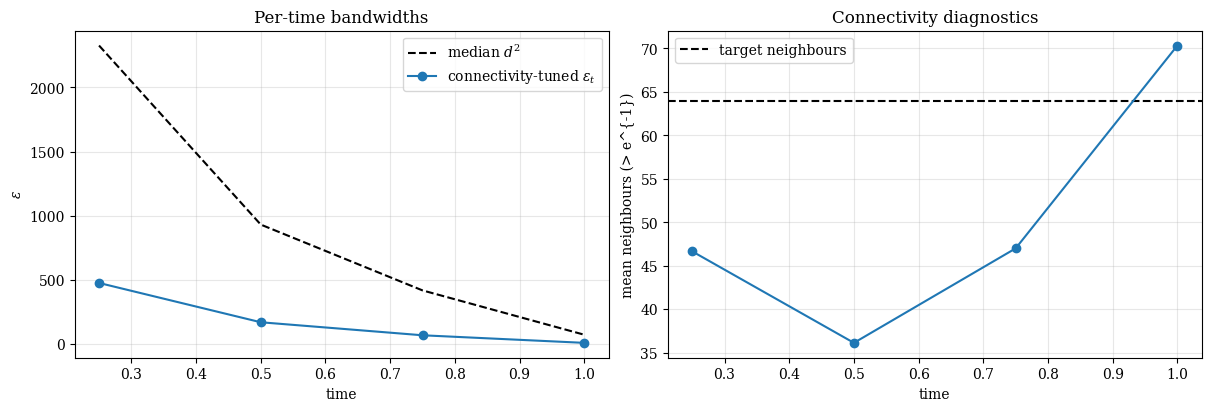

In [33]:
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
ax = axes[0]
ax.plot(times_arr, base_epsilons, 'k--', label='median $d^2$')
ax.plot(times_arr, selected_epsilons, 'o-', label='connectivity-tuned $\epsilon_t$')
ax.set(xlabel='time', ylabel='$\epsilon$', title='Per-time bandwidths')
ax.grid(alpha=0.3)
ax.legend()

ax = axes[1]
ax.axhline(64, color='k', linestyle='--', label='target neighbours')
best = connectivity_df.sort_values('score').groupby('time_idx').first().reset_index()
ax.plot(best['time'], best['mean_neighbors'], 'o-')
ax.set(xlabel='time', ylabel='mean neighbours (> e^{-1})', title='Connectivity diagnostics')
ax.grid(alpha=0.3)
ax.legend()
plt.show()


# %% [markdown]
# ## Time-Coupled Diffusion Maps
# Apply the Marshall–Hirn construction with the tuned bandwidths and variable kernels.

Constructed 4 operators with embedding shape (1000, 8).
Stationary distribution min/max: 0.0009640641612515603 0.0010426349904200855


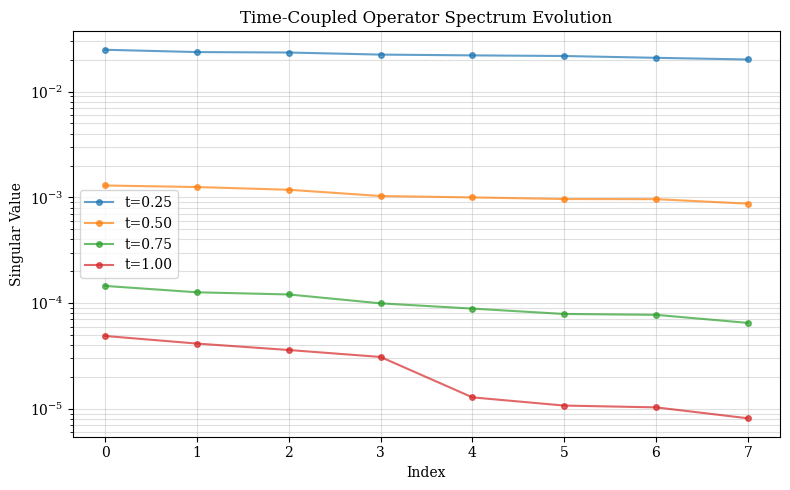

In [34]:
tc_result_finaltime = time_coupled_diffusion_map(
    list(all_frames),
    k=tc_k,
    alpha=tc_alpha,
    epsilons=selected_epsilons,
    variable_bandwidth=use_variable_bandwidth,
    beta=tc_beta,
    density_bandwidths=kde_bandwidths.tolist(),
    t=len(times_arr),
)

print(f"Constructed {len(tc_result_finaltime.transition_operators)} operators with embedding shape {tc_result_finaltime.embedding.shape}.")
print('Stationary distribution min/max:', tc_result_finaltime.stationary_distribution.min(), tc_result_finaltime.stationary_distribution.max())

# Visualize spectrum for each time point
# We need to compute the spectrum for each time step t=1...T
# The function build_time_coupled_trajectory computes this internally.
# Let's use the result from build_time_coupled_trajectory which is computed in the next cell,
# or we can compute it here if we want to see it immediately.

# For immediate visualization, let's compute the trajectory result here temporarily or just wait for the next cell.
# However, the user asked to visualize it *instead* of only the last time.
# The `tc_result_finaltime` only contains the result for the final time `t`.
# To get all spectra, we should use `build_time_coupled_trajectory`.

temp_trajectory = build_time_coupled_trajectory(
    tc_result_finaltime.transition_operators,
    embed_dim=tc_k,
)

plt.figure(figsize=(8, 5))
# Plot spectrum for each time step
for t_idx, sigma_t in enumerate(temp_trajectory.singular_values):
    plt.plot(sigma_t, 'o-', label=f't={times_arr[t_idx]:.2f}', alpha=0.7, markersize=4)

plt.yscale('log')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Time-Coupled Operator Spectrum Evolution')
plt.grid(alpha=0.4, which='both')
# Put legend outside if too many lines
if len(times_arr) > 10:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
else:
    plt.legend()
plt.tight_layout()
plt.show()

Time-coupled embeddings tensor: (4, 1000, 8)


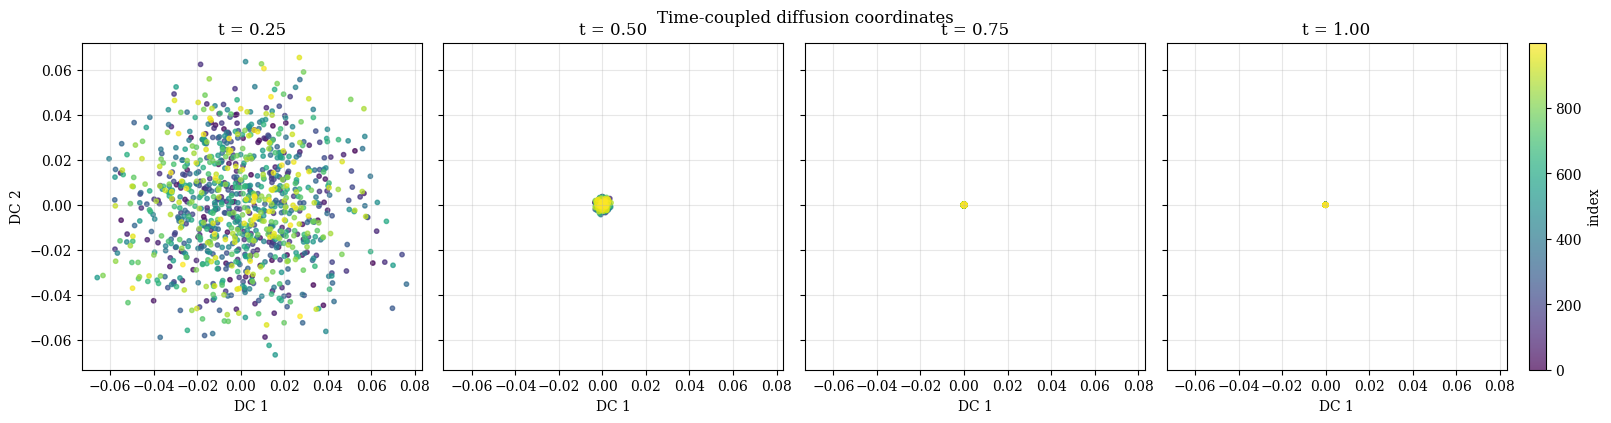

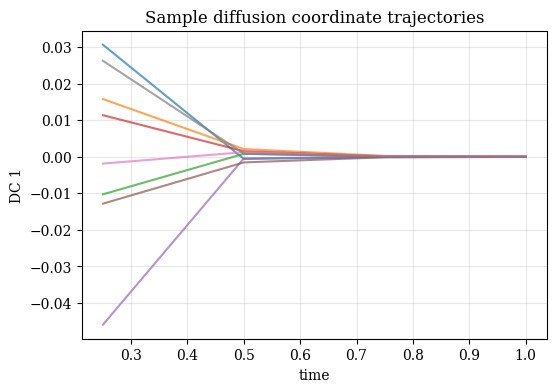

In [35]:
tc_result = build_time_coupled_trajectory(
    tc_result_finaltime.transition_operators,
    embed_dim=tc_k,
)
tc_embeddings_time = tc_result.embeddings
print('Time-coupled embeddings tensor:', tc_embeddings_time.shape)

from matplotlib import colors as mcolors
# use index as coloring
coloring = np.arange(tc_embeddings_time.shape[1])
norm = mcolors.Normalize(vmin=np.min(coloring), vmax=np.max(coloring))
fig, axes = plt.subplots(1, n_times, figsize=(4 * n_times, 4), sharex=True, sharey=True, constrained_layout=True)
if n_times == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    coords = tc_embeddings_time[i]
    sc = ax.scatter(coords[:, 0], coords[:, 1], c=coloring, cmap='viridis', norm=norm, s=10, alpha=0.7)
    ax.set_title(f"t = {times_arr[i]:.2f}")
    ax.set_xlabel('DC 1')
    if i == 0:
        ax.set_ylabel('DC 2')
    ax.grid(alpha=0.3)

fig.colorbar(sc, ax=axes, label='index', fraction=0.046, pad=0.01)
plt.suptitle('Time-coupled diffusion coordinates', y=1.02)
plt.show()

traj_times = times_arr[: tc_embeddings_time.shape[0]]
fig, ax = plt.subplots(figsize=(6, 4))
traj_count = min(8, n_samples)
subset_idx = rng.choice(n_samples, size=traj_count, replace=False)
for idx in subset_idx:
    ax.plot(traj_times, tc_embeddings_time[:, idx, 0], alpha=0.7)
ax.set(xlabel='time', ylabel='DC 1')
ax.set_title('Sample diffusion coordinate trajectories')
ax.grid(alpha=0.3)
plt.show()


In [36]:
train_times = times_arr
holdout_time = 0.75

spline_type = 'pchip'
spline_window_mode = 'triplet'

sample_splines = []
for sample_idx in range(n_samples):
    coords_sample = tc_embeddings_time[:, sample_idx, :]
    splines = fit_coordinate_splines(
        coords_sample,
        train_times,
        spline_type=spline_type,
        window_mode=spline_window_mode,
    )
    sample_splines.append(splines)

g_star = np.vstack([
    evaluate_coordinate_splines(splines, holdout_time).ravel()
    for splines in sample_splines
])
print(f"Spline interpolation complete: {len(sample_splines)} samples; latent dim = {g_star.shape[1]}")


Spline interpolation complete: 1000 samples; latent dim = 8


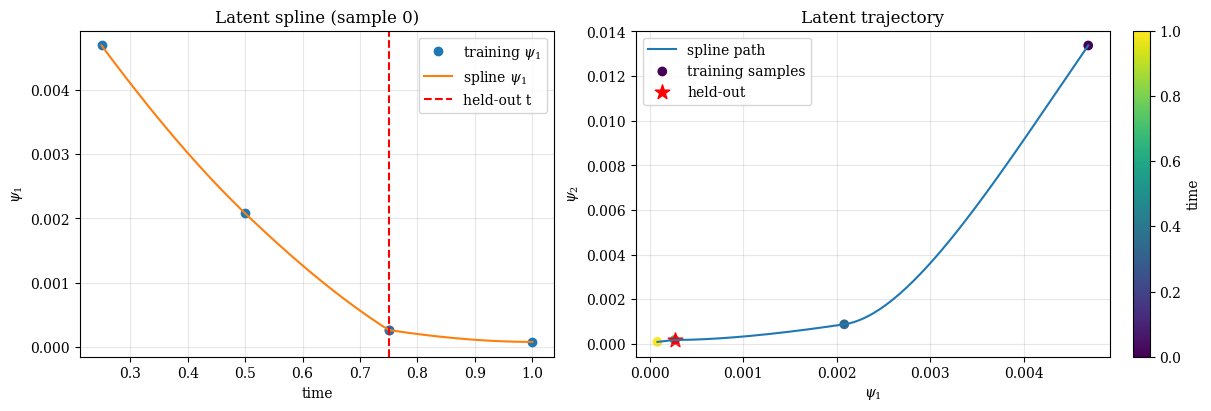

In [37]:

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print('matplotlib is not installed; skipping latent spline visualization.')
else:
    sample_to_plot = 0
    t_dense = np.linspace(train_times.min(), train_times.max(), 200)
    splines = sample_splines[sample_to_plot]
    phi_dense = np.vstack([
        evaluate_coordinate_splines(splines, t).ravel()
        for t in t_dense
    ])

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    axes[0].plot(train_times, tc_embeddings_time[:, sample_to_plot, 0], 'o', label='training $\\psi_1$')
    axes[0].plot(t_dense, phi_dense[:, 0], '-', label='spline $\\psi_1$')
    axes[0].axvline(holdout_time, color='red', linestyle='--', label='held-out t')
    axes[0].scatter([holdout_time], [g_star[sample_to_plot, 0]], color='red')
    axes[0].set(
        xlabel='time',
        ylabel='$\\psi_1$',
        title=f'Latent spline (sample {sample_to_plot})',
    )
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    if phi_dense.shape[1] >= 2:
        axes[1].plot(phi_dense[:, 0], phi_dense[:, 1], '-', color='tab:blue', label='spline path')
        axes[1].scatter(
            tc_embeddings_time[:, sample_to_plot, 0],
            tc_embeddings_time[:, sample_to_plot, 1],
            c=train_times,
            cmap='viridis',
            marker='o',
            label='training samples',
        )
        axes[1].scatter(
            g_star[sample_to_plot, 0],
            g_star[sample_to_plot, 1],
            color='red',
            marker='*',
            s=120,
            label='held-out',
        )
        axes[1].set(
            xlabel='$\\psi_1$',
            ylabel='$\\psi_2$',
            title='Latent trajectory',
        )
        axes[1].legend()
        axes[1].grid(alpha=0.3)
    else:
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, 'Need ≥2 latent dims', ha='center', va='center')
        
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[1], label='time')
    plt.show()

In [38]:
print("Shape of tc_result.singular_values[0].shape:", tc_result.singular_values[0].shape)
print("Shape of tc_result.left_singular_vectors[0].shape:", tc_result.left_singular_vectors[0].shape)
print("Shape of tc_result.embeddings[0].shape:", tc_result.embeddings[0].shape)

Shape of tc_result.singular_values[0].shape: (8,)
Shape of tc_result.left_singular_vectors[0].shape: (1000, 8)
Shape of tc_result.embeddings[0].shape: (1000, 8)


Stacked left singular vectors: (4, 1000, 8)
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Mean err_st to U_global: 7.8609e+00
Mean err_st to U_frechet: 3.1634e+00
Principal angles U_global vs U_frechet (rad): [1.54781658 1.54947574 1.5497764  1.55126746 1.55167952 1.55523149
 1.55688082 1.56062   ]
Log spread → global: 1.9524e+01, Frechet: 5.8681e+00
Log smoothness → global: 3.9457e+01, Frechet: 2.4282e+01


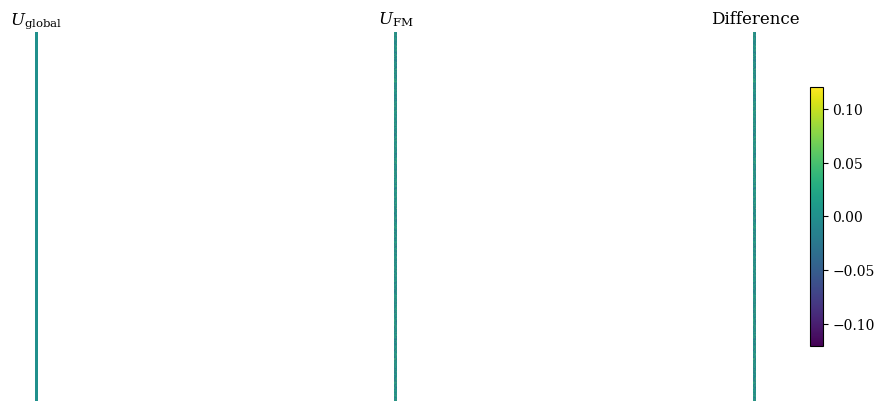

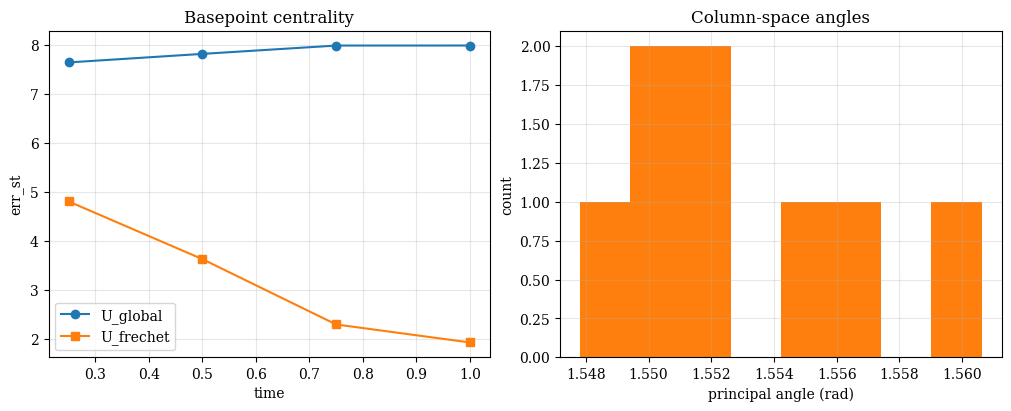

In [39]:
from stiefel.stiefel import batch_stiefel_log, Stiefel_Log, Stiefel_Exp
from stiefel.barycenter import R_barycenter
from stiefel.projection_retraction import (
    st_retr_orthographic,
    st_inv_retr_orthographic,
)
from stiefel.error_measures import err_st
from diffmap.diffusion_maps import _orient_svd
from sklearn.decomposition import TruncatedSVD
# use the symmetric markov operators (used in SVD) and concatenate them as global snapshots
A_concatenated = np.concatenate([tc_result.A_operators[i] for i in range(len(tc_result.A_operators))], axis=1)
svd = TruncatedSVD(n_components=len(tc_result.singular_values[0]) + 1, algorithm='randomized', random_state=42)
svd.fit(A_concatenated)
U_global = svd.transform(A_concatenated)
Vt_global = svd.components_
Sigma_global = svd.singular_values_
U_global, Vt_global = _orient_svd(A_concatenated, U_global, Vt_global)

# remove first trivial component
U_global = U_global[:, 1:]
Vt_global = Vt_global[1:, :]

# Stack trajectory on Stiefel
U_train_list = np.stack(tc_result.left_singular_vectors, axis=0)
n_times, n_samples, stiefel_dim = U_train_list.shape
times_train = train_times  # from notebook
print(f"Stacked left singular vectors: {U_train_list.shape}")

# Compute Frechet mean with orthographic retraction
barycenter_kwargs = dict(stepsize=1.0, max_it=100, tol=1e-8, verbosity=False)
U_frechet, U_bary_iters = R_barycenter(
    points=U_train_list,
    retr=st_retr_orthographic,
    inv_retr=st_inv_retr_orthographic,
    init=U_global,
    **barycenter_kwargs,
)
deltas_global = batch_stiefel_log(U_global, U_train_list, metric_alpha=1e-8, tau=1e-2)
deltas_fm = batch_stiefel_log(U_frechet, U_train_list, metric_alpha=1e-8, tau=1e-2)

# Basic diagnostics for basepoints
err_to_global = np.array([err_st(U_global, U_train_list[t]) for t in range(n_times)])
err_to_frechet = np.array([err_st(U_frechet, U_train_list[t]) for t in range(n_times)])
print(f"Mean err_st to U_global: {err_to_global.mean():.4e}")
print(f"Mean err_st to U_frechet: {err_to_frechet.mean():.4e}")

M = U_global.T @ U_frechet
s = np.linalg.svd(M, compute_uv=False)
principal_angles = np.arccos(np.clip(s, -1.0, 1.0))
print("Principal angles U_global vs U_frechet (rad):", principal_angles)


def _log_spread(deltas_arr: np.ndarray) -> float:
    flat = deltas_arr.reshape(deltas_arr.shape[0], -1)
    return float(np.mean(np.sum(flat * flat, axis=1)))


def stiefel_log_smoothness(deltas_arr: np.ndarray) -> float:
    if deltas_arr.shape[0] < 3:
        return float("nan")
    d2 = deltas_arr[2:] - 2 * deltas_arr[1:-1] + deltas_arr[:-2]
    flat = d2.reshape(d2.shape[0], -1)
    return float(np.mean(np.sum(flat * flat, axis=1)))


spread_global = _log_spread(deltas_global)
spread_fm = _log_spread(deltas_fm)
smooth_global = stiefel_log_smoothness(deltas_global)
smooth_fm = stiefel_log_smoothness(deltas_fm)
print(f"Log spread → global: {spread_global:.4e}, Frechet: {spread_fm:.4e}")
print(f"Log smoothness → global: {smooth_global:.4e}, Frechet: {smooth_fm:.4e}")

if __name__ == "__main__":
    vmax = max(
        np.max(np.abs(U_global)),
        np.max(np.abs(U_frechet)),
        np.max(np.abs(U_frechet - U_global)),
    )
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    ims = [
        axes[0].imshow(U_global, vmin=-vmax, vmax=vmax),
        axes[1].imshow(U_frechet, vmin=-vmax, vmax=vmax),
        axes[2].imshow(U_frechet - U_global, vmin=-vmax, vmax=vmax),
    ]
    axes[0].set_title("$U_{\\mathrm{global}}$")
    axes[1].set_title("$U_{\\mathrm{FM}}$")
    axes[2].set_title("Difference")
    for ax in axes:
        ax.axis("off")
    fig.colorbar(ims[-1], ax=axes, shrink=0.7)
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    axes[0].plot(times_train, err_to_global, "o-", label="U_global")
    axes[0].plot(times_train, err_to_frechet, "s-", label="U_frechet")
    axes[0].set(xlabel="time", ylabel="err_st", title="Basepoint centrality")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].hist(principal_angles, bins=min(20, len(principal_angles)), color="tab:orange")
    axes[1].set(xlabel="principal angle (rad)", ylabel="count", title="Column-space angles")
    axes[1].grid(alpha=0.3)
    plt.show()

In [40]:
from scipy.interpolate import PchipInterpolator

# Define dense time grid for interpolation
t_dense = np.linspace(times_train.min(), times_train.max(), 200)

# --- 1. Stiefel Interpolation (Deltas) for both basepoints ---
def interpolate_deltas(deltas_arr: np.ndarray, base_point: np.ndarray):
    deltas_flat = deltas_arr.reshape(deltas_arr.shape[0], -1)
    pchip = PchipInterpolator(times_train, deltas_flat, axis=0)
    deltas_dense_flat = pchip(t_dense)
    deltas_dense = deltas_dense_flat.reshape(len(t_dense), *base_point.shape)
    U_dense = np.array([Stiefel_Exp(U0=base_point, Delta=d) for d in deltas_dense])
    return deltas_dense, U_dense, pchip


deltas_global_dense, U_dense_global, pchip_delta_global = interpolate_deltas(deltas_global, U_global)
deltas_fm_dense, U_dense_fm, pchip_delta_fm = interpolate_deltas(deltas_fm, U_frechet)
print(f"Stiefel interpolation complete. Shapes → global: {U_dense_global.shape}, Frechet: {U_dense_fm.shape}")

Stiefel interpolation complete. Shapes → global: (200, 1000, 8), Frechet: (200, 1000, 8)


In [41]:
# --- 2. Interpolate Singular Values (Sigma) ---
# Stack singular values from trajectory result
sigmas = np.stack(tc_result.singular_values) # Shape: (n_times, k)

# Interpolate in log-domain
log_sigmas = np.log(sigmas + 1e-16)
pchip_sigma = PchipInterpolator(times_train, log_sigmas, axis=0)
log_sigmas_dense = pchip_sigma(t_dense)
sigmas_dense = np.exp(log_sigmas_dense) # Shape: (n_dense, k)

# --- 3. Interpolate Stationary Distributions (Pi) ---
# Stack stationary distributions
pis = np.stack(tc_result.stationary_distributions) # Shape: (n_times, n_samples)

# Interpolate in log-domain
log_pis = np.log(pis + 1e-16)
pchip_pi = PchipInterpolator(times_train, log_pis, axis=0)
log_pis_dense = pchip_pi(t_dense)
pis_dense_unnorm = np.exp(log_pis_dense)

# Normalize to sum to 1 at each time step
pis_dense = pis_dense_unnorm / pis_dense_unnorm.sum(axis=1, keepdims=True) # Shape: (n_dense, n_samples)

print(f"Sigma dense shape: {sigmas_dense.shape}")
print(f"Pi dense shape: {pis_dense.shape}")

# --- 4. Reconstruct Diffusion Embeddings for both basepoints ---
def reconstruct_embeddings(U_dense: np.ndarray) -> np.ndarray:
    phi_list = []
    for i in range(len(t_dense)):
        U = U_dense[i]
        S = sigmas_dense[i]
        Pi = pis_dense[i]
        phi_list.append((U * S[None, :]) / np.sqrt(Pi)[:, None])
    return np.array(phi_list)


phi_global_dense = reconstruct_embeddings(U_dense_global)
phi_frechet_dense = reconstruct_embeddings(U_dense_fm)
phi_stiefel_dense = phi_global_dense  # keep legacy name for downstream plots
print(f"Reconstructed embeddings → global: {phi_global_dense.shape}, Frechet: {phi_frechet_dense.shape}")

Sigma dense shape: (200, 8)
Pi dense shape: (200, 1000)
Reconstructed embeddings → global: (200, 1000, 8), Frechet: (200, 1000, 8)


In [42]:
# Hold-out evaluation on odd time indices
all_indices = np.arange(n_times)
train_idx = all_indices[::2]
val_idx = all_indices[1::2]

train_times_sub = times_train[train_idx]
val_times_sub = times_train[val_idx]


def interpolate_split(deltas_arr: np.ndarray, base_point: np.ndarray):
    deltas_train = deltas_arr[train_idx].reshape(len(train_idx), -1)
    pchip = PchipInterpolator(train_times_sub, deltas_train, axis=0)
    deltas_val_flat = pchip(val_times_sub)
    deltas_val = deltas_val_flat.reshape(len(val_idx), *base_point.shape)
    U_pred = np.array([Stiefel_Exp(U0=base_point, Delta=d) for d in deltas_val])
    return U_pred, pchip


U_pred_global_val, pchip_delta_global_cv = interpolate_split(deltas_global, U_global)
U_pred_fm_val, pchip_delta_fm_cv = interpolate_split(deltas_fm, U_frechet)

U_true_val = U_train_list[val_idx]
err_st_global_val = np.array([err_st(U_pred_global_val[i], U_true_val[i]) for i in range(len(val_idx))])
err_st_fm_val = np.array([err_st(U_pred_fm_val[i], U_true_val[i]) for i in range(len(val_idx))])
print(f"Mean validation err_st → global: {err_st_global_val.mean():.4e}, Frechet: {err_st_fm_val.mean():.4e}")

# Embedding hold-out
log_sigmas_train = log_sigmas[train_idx]
pchip_sigma_cv = PchipInterpolator(train_times_sub, log_sigmas_train, axis=0)
sigmas_val = np.exp(pchip_sigma_cv(val_times_sub))

log_pis_train = log_pis[train_idx]
pchip_pi_cv = PchipInterpolator(train_times_sub, log_pis_train, axis=0)
pis_val_unnorm = np.exp(pchip_pi_cv(val_times_sub))
pis_val = pis_val_unnorm / pis_val_unnorm.sum(axis=1, keepdims=True)


def reconstruct_val_embeddings(U_pred: np.ndarray) -> np.ndarray:
    out = []
    for i in range(len(val_idx)):
        out.append((U_pred[i] * sigmas_val[i][None, :]) / np.sqrt(pis_val[i])[:, None])
    return np.array(out)


phi_global_val = reconstruct_val_embeddings(U_pred_global_val)
phi_frechet_val = reconstruct_val_embeddings(U_pred_fm_val)
phi_true_val = tc_embeddings_time[val_idx]

embedding_mse_global = float(np.mean((phi_global_val - phi_true_val) ** 2))
embedding_mse_fm = float(np.mean((phi_frechet_val - phi_true_val) ** 2))
print(f"Validation embedding MSE → global: {embedding_mse_global:.4e}, Frechet: {embedding_mse_fm:.4e}")


Mean validation err_st → global: 3.7090e+00, Frechet: 4.5436e+00
Validation embedding MSE → global: 5.5292e-07, Frechet: 6.6248e-07


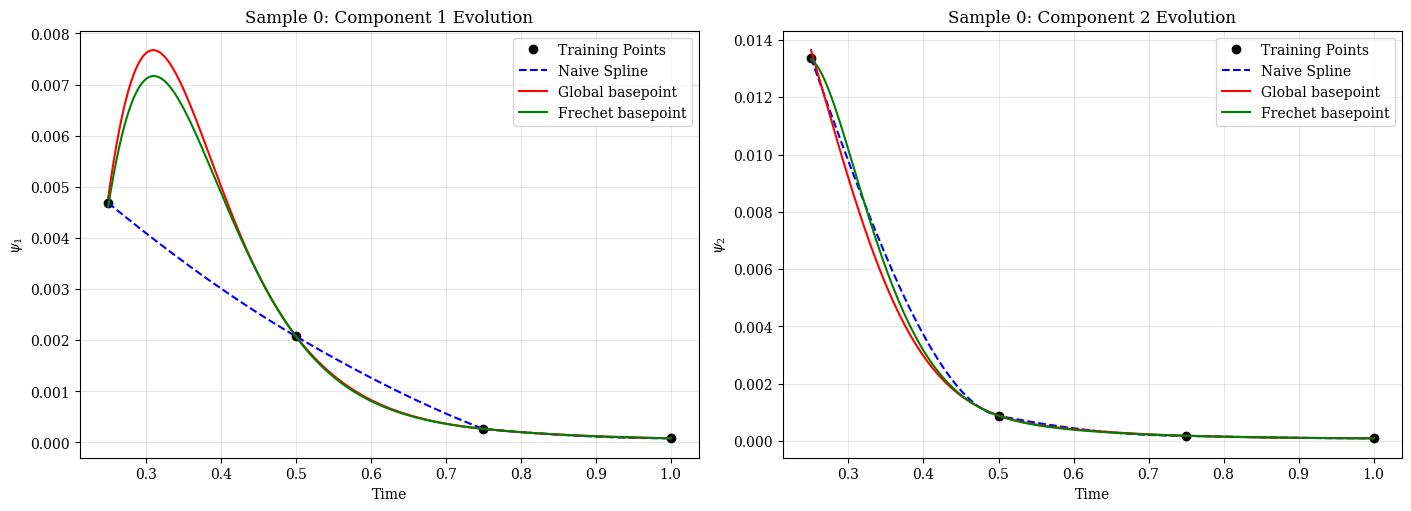

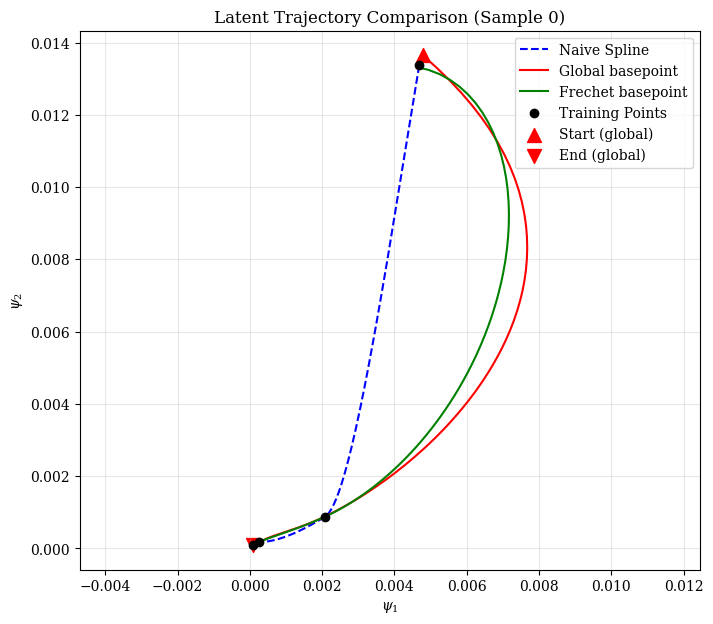

In [43]:
# --- 5. Comparison: Naive Spline vs Global Stiefel vs Frechet Stiefel ---

sample_idx = 0  # Choose sample to visualize

# 1. Get Naive Spline Trajectory for this sample
splines_sample = sample_splines[sample_idx]
phi_naive_sample = np.vstack(
    [evaluate_coordinate_splines(splines_sample, t).ravel() for t in t_dense]
)

# 2. Stiefel Interpolations
phi_global_sample = phi_global_dense[:, sample_idx, :]
phi_frechet_sample = phi_frechet_dense[:, sample_idx, :]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# Component 1 vs Time
axes[0].plot(times_train, tc_embeddings_time[:, sample_idx, 0], 'ko', label='Training Points')
axes[0].plot(t_dense, phi_naive_sample[:, 0], 'b--', label='Naive Spline')
axes[0].plot(t_dense, phi_global_sample[:, 0], 'r-', label='Global basepoint')
axes[0].plot(t_dense, phi_frechet_sample[:, 0], 'g-', label='Frechet basepoint')
axes[0].set_title(f'Sample {sample_idx}: Component 1 Evolution')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('$\\psi_1$')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Component 2 vs Time
axes[1].plot(times_train, tc_embeddings_time[:, sample_idx, 1], 'ko', label='Training Points')
axes[1].plot(t_dense, phi_naive_sample[:, 1], 'b--', label='Naive Spline')
axes[1].plot(t_dense, phi_global_sample[:, 1], 'r-', label='Global basepoint')
axes[1].plot(t_dense, phi_frechet_sample[:, 1], 'g-', label='Frechet basepoint')
axes[1].set_title(f'Sample {sample_idx}: Component 2 Evolution')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('$\\psi_2$')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()

# 2D Trajectory Plot (Phase Plane)
plt.figure(figsize=(8, 7))
plt.plot(phi_naive_sample[:, 0], phi_naive_sample[:, 1], 'b--', label='Naive Spline')
plt.plot(phi_global_sample[:, 0], phi_global_sample[:, 1], 'r-', label='Global basepoint')
plt.plot(phi_frechet_sample[:, 0], phi_frechet_sample[:, 1], 'g-', label='Frechet basepoint')
plt.scatter(
    tc_embeddings_time[:, sample_idx, 0],
    tc_embeddings_time[:, sample_idx, 1],
    c='k',
    zorder=5,
    label='Training Points',
)

# Mark start and end (global view)
plt.scatter(phi_global_sample[0, 0], phi_global_sample[0, 1], c='r', marker='^', s=100, label='Start (global)')
plt.scatter(phi_global_sample[-1, 0], phi_global_sample[-1, 1], c='r', marker='v', s=100, label='End (global)')

plt.xlabel('$\\psi_1$')
plt.ylabel('$\\psi_2$')
plt.title(f'Latent Trajectory Comparison (Sample {sample_idx})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()


<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1534388/575944292.py:22: SyntaxWarning: invalid escape sequence '\p'
  axes[0].set_ylabel('$\psi_1$')
/tmp/ipykernel_1534388/575944292.py:31: SyntaxWarning: invalid escape sequence '\p'
  axes[1].set_ylabel('$\psi_2$')
/tmp/ipykernel_1534388/575944292.py:39: SyntaxWarning: invalid escape sequence '\p'
  axes[2].set_xlabel('$\psi_1$')
/tmp/ipykernel_1534388/575944292.py:40: SyntaxWarning: invalid escape sequence '\p'
  axes[2].set_ylabel('$\psi_2$')


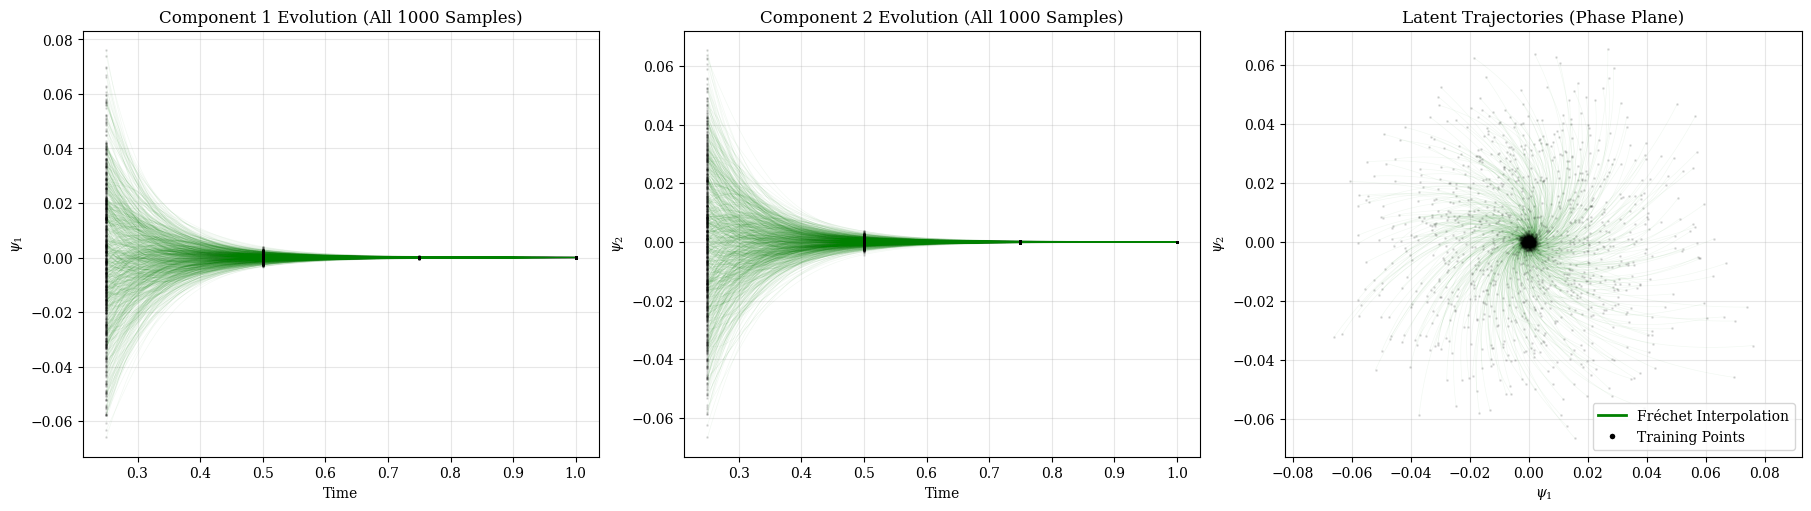

Training pairs collected: macro (3000, 8), micro (3000, 390)
Time-augmented training data: macro (3000, 8), times (3000,), micro (3000, 390)
KRR hyperparameters → sigma_g=2.964e-03, sigma_t=9.375e-02, gamma=1.333e+00, lambda=1.000e-03
method             RMSE     RelErr        MAE     |Δvol|       Δvol
-------------------------------------------------------------------
gh            1.130e-01  2.942e-03  9.523e-02  6.803e-03  1.128e-05
gh_local      1.128e-01  2.935e-03  9.501e-02  6.799e-03  1.063e-05
convex        9.459e-02  2.464e-03  7.760e-02  7.433e-03  4.766e-05
krr_time_local  1.134e-01  2.951e-03  9.551e-02  6.802e-03 -1.858e-06


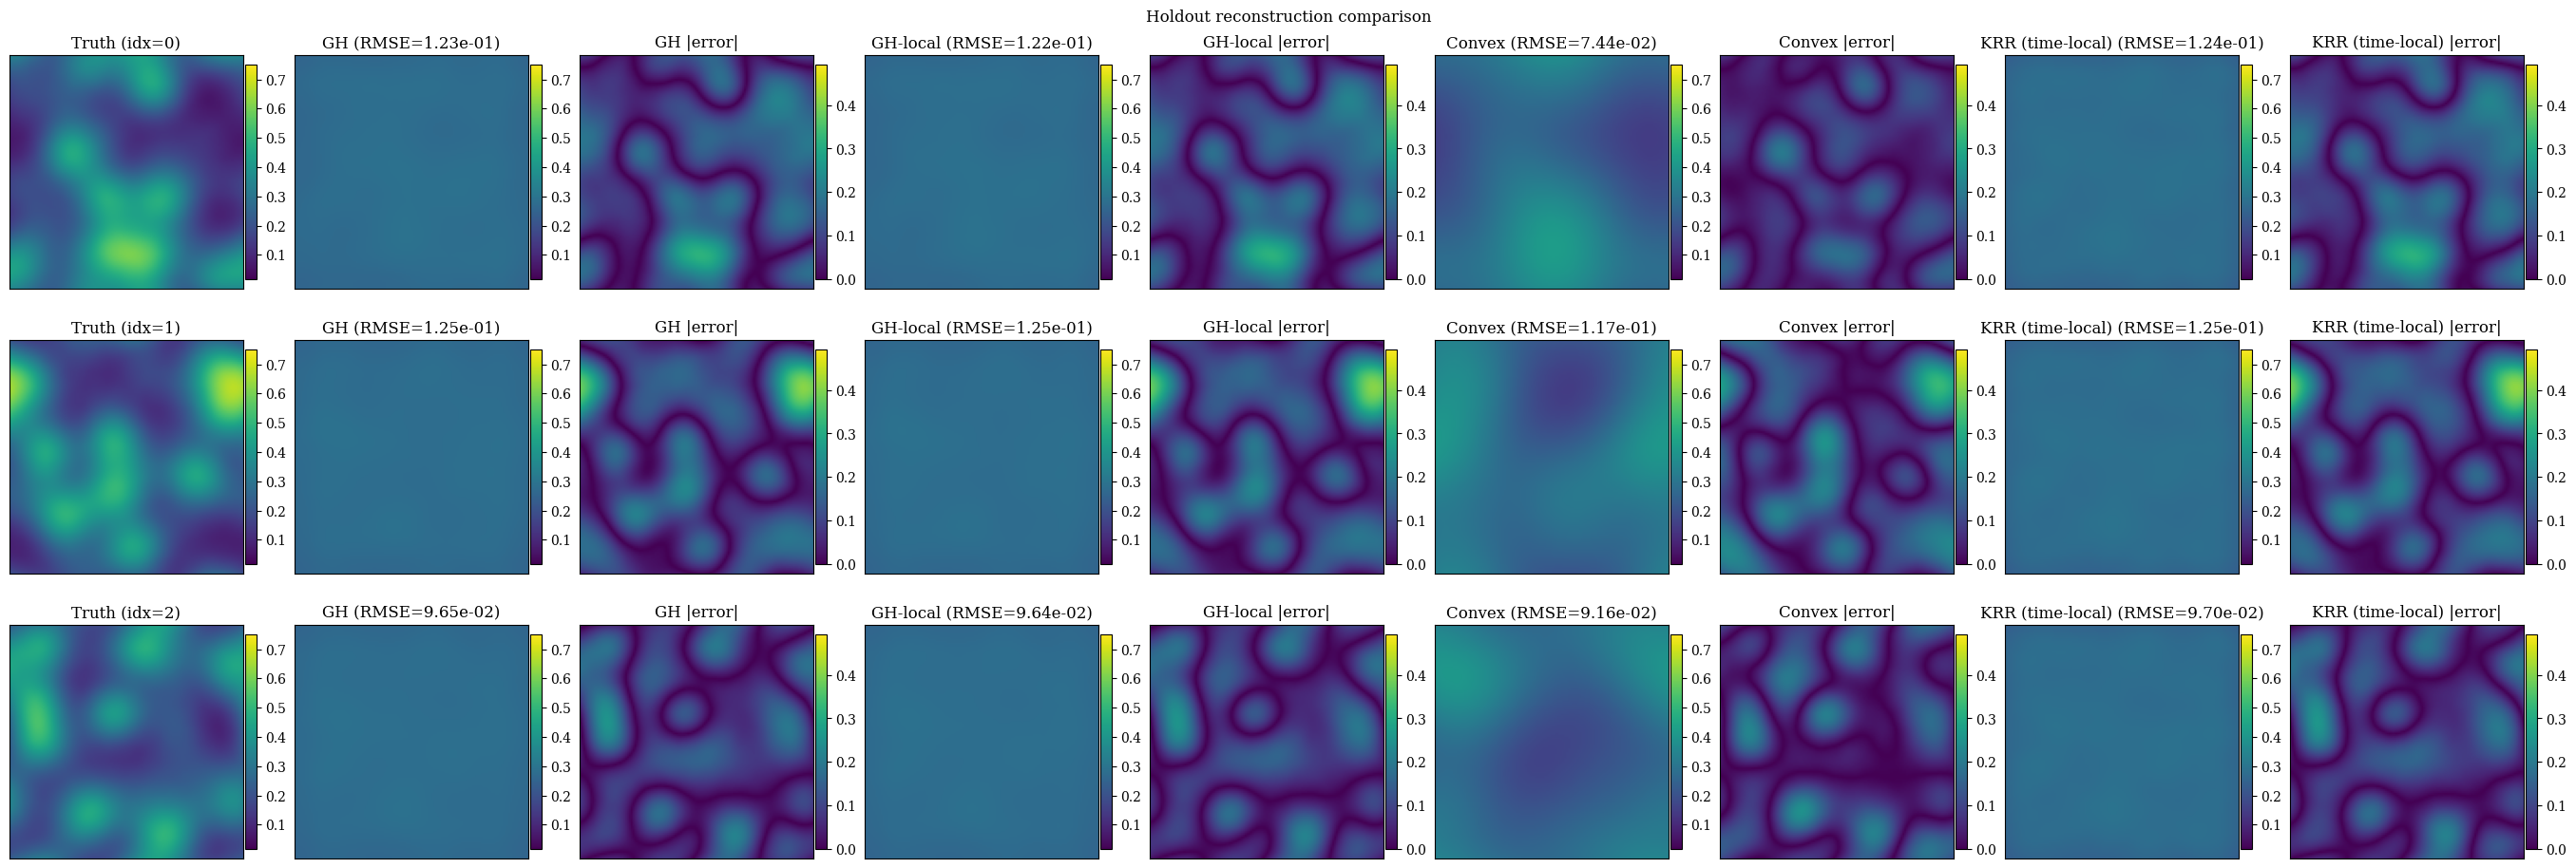

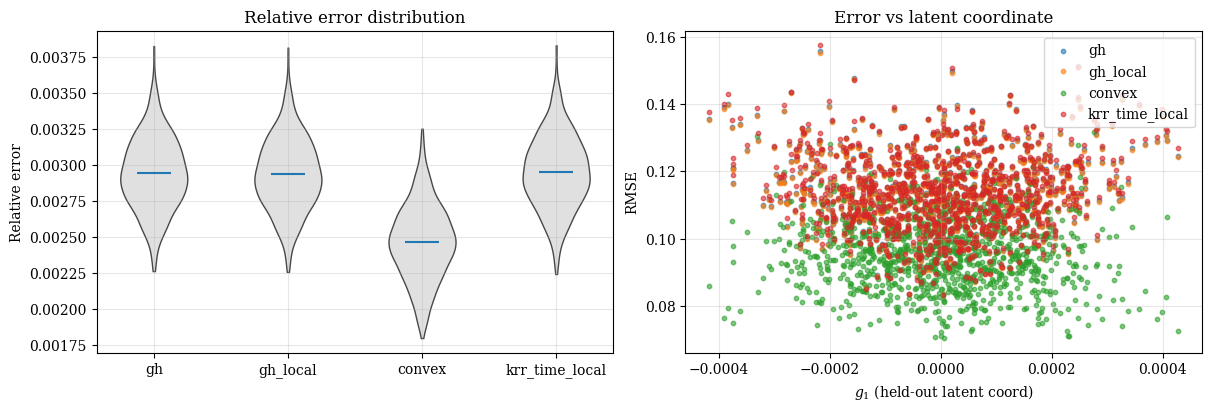

In [44]:
# --- 6. Visualize Interpolation for All Samples (Fréchet Basepoint) ---

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Plot parameters
alpha_val = 0.05
color_interp = 'g'
color_train = 'k'

n_samples_total = phi_frechet_dense.shape[1]

# Component 1 vs Time
# Plot all trajectories at once: (n_dense, n_samples)
axes[0].plot(t_dense, phi_frechet_dense[:, :, 0], color=color_interp, alpha=alpha_val, linewidth=0.5)
# Scatter training points
# Flatten time to match flattened embeddings: (n_times * n_samples)
t_flat = np.repeat(times_train, n_samples_total)
axes[0].scatter(t_flat, tc_embeddings_time[:, :, 0].flatten(), 
                color=color_train, s=1, alpha=0.1, zorder=2)
axes[0].set_title(f'Component 1 Evolution (All {n_samples_total} Samples)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('$\psi_1$')
axes[0].grid(True, alpha=0.3)

# Component 2 vs Time
axes[1].plot(t_dense, phi_frechet_dense[:, :, 1], color=color_interp, alpha=alpha_val, linewidth=0.5)
axes[1].scatter(t_flat, tc_embeddings_time[:, :, 1].flatten(), 
                color=color_train, s=1, alpha=0.1, zorder=2)
axes[1].set_title(f'Component 2 Evolution (All {n_samples_total} Samples)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('$\psi_2$')
axes[1].grid(True, alpha=0.3)

# Phase Plane
axes[2].plot(phi_frechet_dense[:, :, 0], phi_frechet_dense[:, :, 1], color=color_interp, alpha=alpha_val, linewidth=0.5)
axes[2].scatter(tc_embeddings_time[:, :, 0].flatten(), tc_embeddings_time[:, :, 1].flatten(), 
                color=color_train, s=1, alpha=0.1, zorder=2)
axes[2].set_title('Latent Trajectories (Phase Plane)')
axes[2].set_xlabel('$\psi_1$')
axes[2].set_ylabel('$\psi_2$')
axes[2].grid(True, alpha=0.3)
axes[2].axis('equal')

# Add a custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color_interp, lw=2),
                Line2D([0], [0], marker='o', color='w', markerfacecolor=color_train, markersize=5)]
axes[2].legend(custom_lines, ['Fréchet Interpolation', 'Training Points'], loc='best')

plt.show()


@dataclass
class LiftingConfig:
    holdout_time: float = 0.75
    gh_delta: float = 1e-3
    gh_ridge: float = 1e-6
    gh_local_delta: float = 5e-3
    gh_local_ridge: float = 1e-3
    gh_local_neighbors: int = 128
    gh_local_max_modes: int = 8
    convex_k: int = 64
    convex_max_iter: int = 200
    krr_spatial_length_scale: Optional[float] = None
    krr_temporal_length_scale: Optional[float] = None
    krr_time_scaling: Optional[float] = None
    krr_ridge_penalty: float = 1e-3
    plot_samples: tuple[int, ...] = (0, 1, 2)
    vmax_mode: Literal["global", "per_sample"] = "global"
    time_match_tol: float = 1e-8


if __name__ == "__main__":
    config = LiftingConfig()
    macro_train, micro_train = build_training_pairs(
        tc_embeddings_time,
        all_frames,
        times_arr,
        config.holdout_time,
        tol=config.time_match_tol,
    )
    macro_train_coords, train_time_values, micro_train_states = build_time_augmented_training_pairs(
        macro_time_series=tc_embeddings_time,
        micro_time_series=all_frames,
        snapshot_times=times_arr,
        holdout_snapshot_time=config.holdout_time,
        tol=config.time_match_tol,
    )
    print(f"Training pairs collected: macro {macro_train.shape}, micro {micro_train.shape}")
    print(
        "Time-augmented training data:",
        f"macro {macro_train_coords.shape}, times {train_time_values.shape}, micro {micro_train_states.shape}",
    )

    time_span = float(times_arr.max() - times_arr.min()) if times_arr.size > 0 else 1.0
    if config.krr_spatial_length_scale is None:
        centered_macro = macro_train_coords - macro_train_coords.mean(axis=0)
        macro_norms = np.linalg.norm(centered_macro, axis=1)
        median_norm = float(np.median(macro_norms)) if macro_norms.size > 0 else 1.0
        config.krr_spatial_length_scale = median_norm if median_norm > 0 else 1.0
    if config.krr_temporal_length_scale is None:
        temporal_guess = 0.5 * time_span / max(len(times_arr), 1)
        config.krr_temporal_length_scale = temporal_guess if temporal_guess > 0 else 1.0
    if config.krr_time_scaling is None:
        config.krr_time_scaling = 1.0 / time_span if time_span > 0 else 1.0
    print(
        "KRR hyperparameters \u2192 "
        f"sigma_g={config.krr_spatial_length_scale:.3e}, "
        f"sigma_t={config.krr_temporal_length_scale:.3e}, "
        f"gamma={config.krr_time_scaling:.3e}, "
        f"lambda={config.krr_ridge_penalty:.3e}"
    )

    gh_model = fit_geometric_harmonics(
        intrinsic_coords=macro_train,
        samples=micro_train,
        epsilon_star=None,
        delta=config.gh_delta,
        ridge=config.gh_ridge,
        grid_shape=None,
        center=True,
    )
    gh_lifts = lift_with_geometric_harmonics(
        gh_model,
        g_star,
        local_delta=config.gh_local_delta,
        local_ridge=config.gh_local_ridge,
        local_neighbors=config.gh_local_neighbors,
        max_local_modes=config.gh_local_max_modes,
    )
    chi = ConvexHullInterpolator(macro_states=macro_train, micro_states=micro_train)
    X_convex = lift_with_convex_hull(
        chi,
        g_star,
        k=config.convex_k,
        max_iter=config.convex_max_iter,
    )
    X_krr = lift_with_time_local_kernel_ridge(
        macro_time_series=tc_embeddings_time,
        micro_time_series=all_frames,
        snapshot_times=times_arr,
        holdout_snapshot_time=config.holdout_time,
        g_star=g_star,
        spatial_length_scale=config.krr_spatial_length_scale,
        temporal_length_scale=config.krr_temporal_length_scale,
        time_scaling=config.krr_time_scaling,
        ridge_penalty=config.krr_ridge_penalty,
    )

    holdout_idx = find_holdout_index(times_arr, config.holdout_time, tol=config.time_match_tol)
    X_true_pca = all_frames[holdout_idx]

    if components is None or mean_vec is None:
        raise RuntimeError("PCA metadata missing; cannot decode fields for lifting comparison.")

    X_true_flat = pca_decode(
        X_true_pca, components, mean_vec, explained_variance, is_whitened, whitening_epsilon
    )
    X_gh_flat = pca_decode(
        gh_lifts["global"], components, mean_vec, explained_variance, is_whitened, whitening_epsilon
    )
    X_gh_local_flat = pca_decode(
        gh_lifts["local"], components, mean_vec, explained_variance, is_whitened, whitening_epsilon
    )
    X_convex_flat = pca_decode(
        X_convex, components, mean_vec, explained_variance, is_whitened, whitening_epsilon
    )
    X_krr_flat = pca_decode(
        X_krr, components, mean_vec, explained_variance, is_whitened, whitening_epsilon
    )

    imgs_true = to_images(X_true_flat, resolution)
    imgs_gh = to_images(X_gh_flat, resolution)
    imgs_gh_local = to_images(X_gh_local_flat, resolution)
    imgs_convex = to_images(X_convex_flat, resolution)
    imgs_krr = to_images(X_krr_flat, resolution)

    lift_metrics = compute_lift_metrics(
        X_true_flat,
        X_gh_flat,
        X_gh_local_flat,
        X_convex_flat,
        X_krr_flat,
    )
    print_metric_table(lift_metrics)

    sample_indices = tuple(idx for idx in config.plot_samples if idx < n_samples)
    if not sample_indices:
        sample_indices = (0,)
    plot_field_comparisons(
        imgs_true,
        imgs_gh,
        imgs_gh_local,
        imgs_convex,
        sample_indices=sample_indices,
        imgs_krr=imgs_krr,
        vmax_mode=config.vmax_mode,
    )
    plot_error_statistics(lift_metrics, g_star)
